# Wisconsin Breast Cancer Machine Learning
## NOT COMPLETE

+ Contributor: Raul Eulogio

# Abstract 

For this project, I implemented a **Random Forest Model** on a data set containing descriptive attributes of digitized images of a process known as, *fine needle aspirate* (**FNA**) of breast mass. 

We have a total of 29 features that were computed for each cell nucleus with an ID Number and the Diagnosis (Later converted to binary representations: *Malignant* = **1**, *Benign* = **0**). 

<img src="https://www.researchgate.net/profile/Glaucia_Sizilio/publication/232811011/figure/fig3/AS:214220353347586@1428085520095/Captured-images-of-layers-of-glass-with-smears-of-breast-massobtained-by-FNA-the-parts.png">


+ Ex. Image of a malignant solitary fibrous tumor using **FNA**. 
+ Source by [Glaucia Rma Sizilio](https://www.researchgate.net/profile/Glaucia_Sizilio), [Cicilia Rm Leite](https://www.researchgate.net/profile/Cicilia_Leite), [Ana Mg Guerreiro](https://www.researchgate.net/scientific-contributions/2069488816_Ana_Mg_Guerreiro), and [Adriao D Doria Neto](https://www.researchgate.net/profile/Adriao_Duarte_Neto)

# Introduction

Don't focus on data set focus on the random forest model

## Origins

This data set originated in early 1990's, when Dr. William H. Wolberg was curious if he could find a way to accurately predict breast cancer diagnosis based on **FNA**'s. 

The research was broken down into two parts; the extraction of the data (which we will go over) and the classficattion (if you want to read more find information on this section [here](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.74.6745&rep=rep1&type=pdf)). 

### Steps Taken

+ **FNA**'s were done on a total of 569 patients, once done the samples were then stained to help differentiate distinguished cell nuclei
+ Samples were classified as cancer-based through biopsy and historical confirmation. Non-cancer samples were confirmed by biopsy or follow ups. 
+ Users then chose areas of the **FNA** with minimal overlap between nuclei; they then took scans utilizing a digital camera. 
+ Using a software called `Xcyt`, the team created approximate boundaries, which would then used a process called [snakes](https://en.wikipedia.org/wiki/Active_contour_model) which converged to give the exact nuclei boundary. 
+ Finally, once the boundaries for the nuclei were set, calculations were made resulting in 29 features, creating this data set!

More information regarding the process can be found [here](http://pages.cs.wisc.edu/~olvi/uwmp/cancer.html). I will source them at the end of the project as well, but I found these to be interesting reads especially since I've seen the data set used heavily without a lot of context as to how the data was actually extracted. More information [here](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.74.6745&rep=rep1&type=pdf)

## Motivation

This is popular data set used for machine learning purposes.

I employ critical data analysis modules in this project, emphasizing on: 

+ `pandas`
+ `scikit learn` 
+ `matplotlib` (for visuals)
+ `seaborn` (easier to make statistical plots)

# Load Packages 
We load our modules into our python environment. In my case I am employing a `Jupyter Notebook` while running inside a `virtualenv` environment.

In [1]:
# Import modules
%matplotlib inline

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from urllib.request import urlopen 

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500) 

# Load Data
For this section, I'll load the data into a **Pandas** dataframe using `urlopen` from the `urllib.request` module. 

Instead of downloading a **csv**, I started implementing this method(Inspired by [Jason's Python Tutorials](https://github.com/JasonFreeberg/PythonTutorials)) where I grab the data straight from the [UCI Machine Learning Database](https://archive.ics.uci.edu/ml/datasets.html) using an http request. This makes it easier to go about analysis from online sources and cuts out the need to download/upload a **csv** file when uploading on *GitHub*, since most files in the UCI database are easily accessible in the desired format. Finally, I created a list with the appropriate names and set them as the column names. 



**NOTE**: Original Data set can also be found [here](ftp://ftp.cs.wisc.edu/math-prog/cpo-dataset/machine-learn/cancer/WDBC/WDBC.dat)

Also often it is considered bad practice to not have a static file for data set, but this data set is very old and only be edited for any time soon, so I usually use the source, but you can save a `csv` file and include it in your repo. 

In [2]:
# Loading data and cleaning dataset
UCI_data_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases\
/breast-cancer-wisconsin/wdbc.data'

In [3]:
names = ['id_number', 'diagnosis', 'radius_mean', 
         'texture_mean', 'perimeter_mean', 'area_mean', 
         'smoothness_mean', 'compactness_mean', 
         'concavity_mean','concave_points_mean', 
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se', 
         'area_se', 'smoothness_se', 'compactness_se', 
         'concavity_se', 'concave_points_se', 
         'symmetry_se', 'fractal_dimension_se', 
         'radius_worst', 'texture_worst', 
         'perimeter_worst', 'area_worst', 
         'smoothness_worst', 'compactness_worst', 
         'concavity_worst', 'concave_points_worst', 
         'symmetry_worst', 'fractal_dimension_worst'] 

dx = ['Benign', 'Malignant']

In [4]:
breast_cancer = pd.read_csv(urlopen(UCI_data_URL), names=names)

## Data Cleaning

In [5]:
# Setting 'id_number' as our index
breast_cancer.set_index(['id_number'], inplace = True) 
# Converted to binary to help later on with models and plots
breast_cancer['diagnosis'] = breast_cancer['diagnosis'].map({'M':1, 'B':0})

# Exploratory Analysis
An important aspect of data analysis is to create a narrative with your data. The ability to create analysis that gives insight to potential collaborators, and a more general audience helps ensure .

I will start with the `head()` function to give a preview of the entire data set. 


## Scatter Plot Matrix
Scatter Plot Matrices are a useful tool to uncover trends within our data set.

Utilizing `seaborn`'s `pairplot()` we can show various plots that show 2 variable interactions where we will be using color to indicate diagnosis. *Red* indicates bengin and *Purple* indicates malignant. 

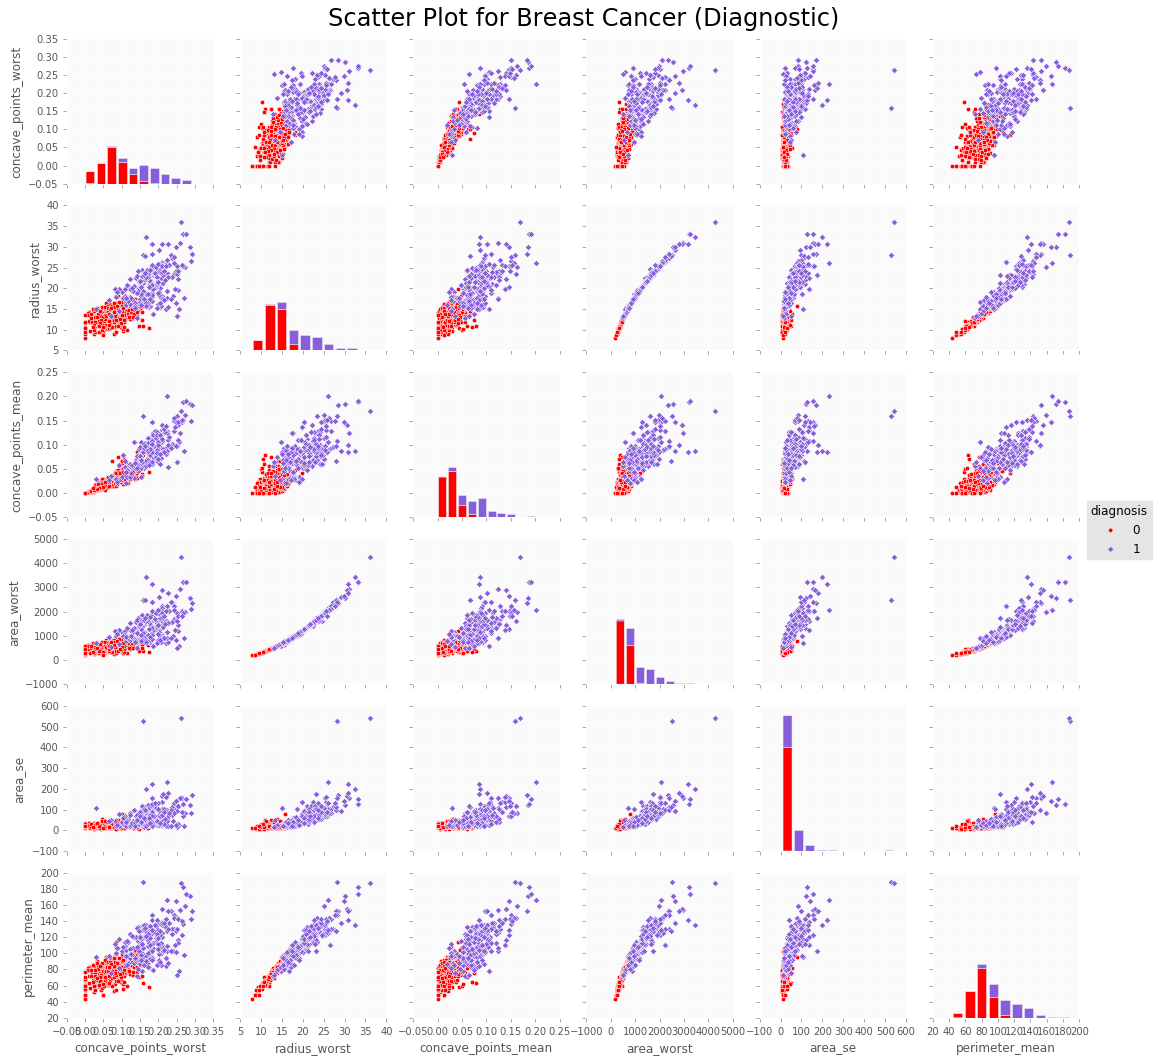

In [6]:
# Scatterplot Matrix
# Variables chosen from Random Forest modeling.
cols = ['concave_points_worst', 'radius_worst',
        'concave_points_mean', 'area_worst', 'area_se',
       'perimeter_mean']

g = sns.pairplot(breast_cancer,
             vars = cols,
             hue = 'diagnosis', 
             palette = ('Red', '#875FDB'), 
             markers=["o", "D"])

g.set(axis_bgcolor = '#fafafa')
# Inspired by http://mlwhiz.com/blog/2015/09/13/seaborn_visualizations/
# Since I was having trouble including title in scatter plot!
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Scatter Plot for Breast Cancer (Diagnostic)',
              fontsize = 24)

Using 5 variables from our data set (the top variables that our *random forest* model outputted), we can see some distinct relationships and trends that differentiate the two diagnoses. 

## Heat Map


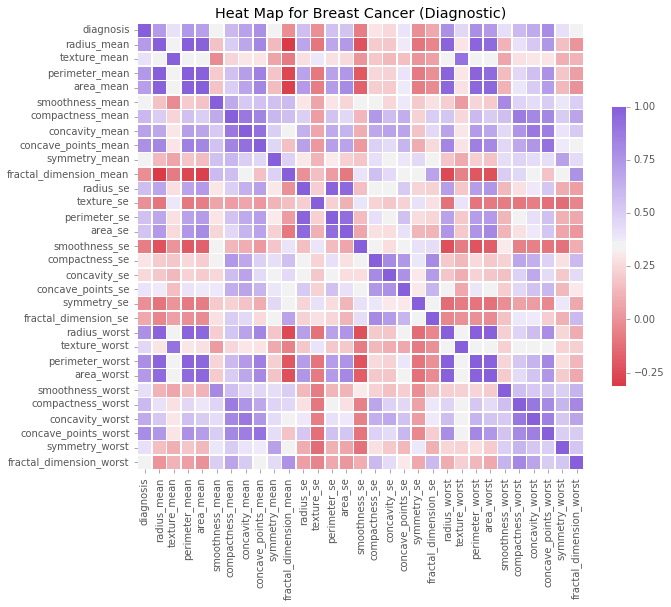

In [7]:
corr = breast_cancer.corr(method = 'pearson') # Correlation Matrix

fig, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 275, as_cmap=True)

ax.set_title('Heat Map for Breast Cancer (Diagnostic)')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap,
            square=True, xticklabels=True, 
            yticklabels=True, linewidths=.5, 
            cbar_kws={"shrink": .5})

In [8]:
def plot_box_plot(data_frame, data_set_name, xlim=None):
    """
    Purpose
    ----------
    Creates a seaborn boxplot including all dependent 
    variables and includes x limit parameters

    Args:
    ----------
    data_frame:   Name of pandas.dataframe 
    data_set_name: Name of title for the boxplot
    xlim :         Set upper and lower x-limits
    
    Returns:
    ----------
    Box plot with specified data_frame, title, and x-limits 
    """

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.set_axis_bgcolor('#fafafa')
    if xlim is not None:
        plt.xlim(*xlim)
    plt.ylabel('Dependent Variables')
    plt.title("Box Plot of {0} Data Set"\
        .format(data_set_name))
    ax = sns.boxplot(data = data_frame,
                     orient = 'h', 
                     palette = 'Set2')

    plt.show()
    plt.close()

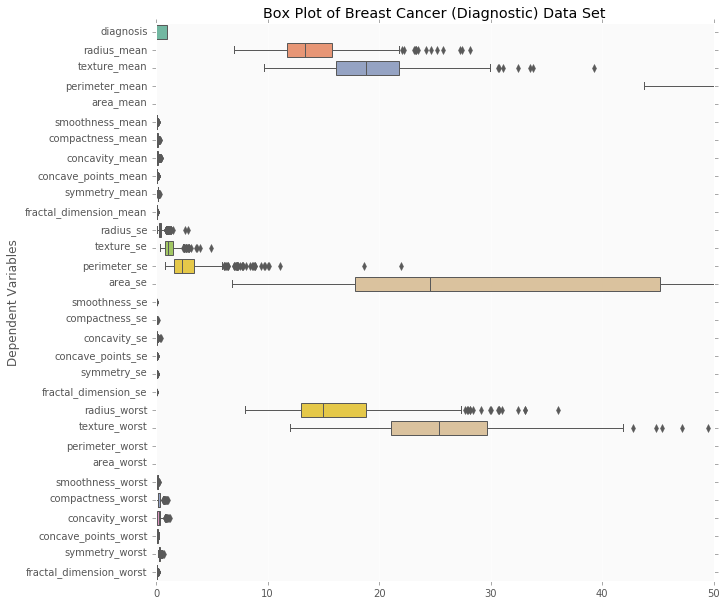

In [9]:
plot_box_plot(breast_cancer, 
              'Breast Cancer (Diagnostic)', 
              (-.05, 50))

In [10]:
def normalize_data_frame(data_frame):
    """
    Purpose
    ----------
    Function created to normalize data set.
    Intializes an empty data frame which will normalize all columns that
    have at > 10 unique values (chosen arbitrarily since target columns
    will have classes < 10) and append the non-float types.
    Application can vary significantly for different data set, use with caution
    or modify accordingly.

    Parameters
    ----------
    * data_frame: 	Name of pandas.dataframe

    Returns
    ----------
    * data_frame_norm:	Normalized dataframe values ranging (0, 1)
    """
    data_frame_norm = pd.DataFrame()
    for col in data_frame:
        if ((len(np.unique(data_frame[col])) > 10) & (data_frame[col].dtype != 'object')):
            data_frame_norm[col]=((data_frame[col] - data_frame[col].min()) /
                                  (data_frame[col].max() - data_frame[col].min()))
        else:
            data_frame_norm[col] = data_frame[col]
    return data_frame_norm

breast_cancer_norm = normalize_data_frame(breast_cancer)

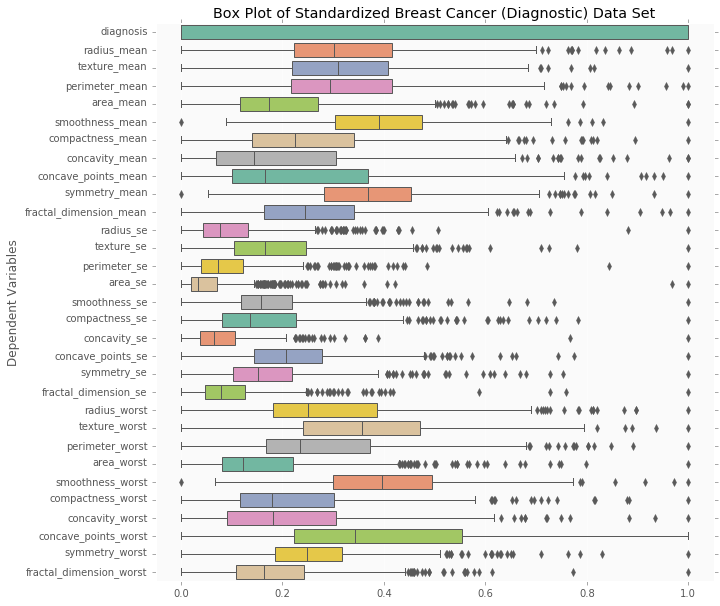

In [12]:
plot_box_plot(breast_cancer_norm, 
              'Standardized Breast Cancer (Diagnostic)', 
              (-.05, 1.05))